XGBoost + SHAP
Grecia Paola Siono Gutierrez

Methodology:
-Train one XGBoost Regressor for each target output, since all outputs—surface consumed, mid-story consumed, and canopy consumed, are continuous variables.
-Include both discrete and continuous input variables as predictors.
-Apply Label Encoding to discrete variables, as XGBoost handles label-encoded categoricals effectively.
-Use SHAP (SHapley Additive exPlanations) with the TreeExplainer to interpret feature importance for each model:
-SHAP values help identify which features contribute most to predictions.
-Use summary_plot() and dependence_plot() to visualize global and local feature impacts.
-Evaluate the model using appropriate regression metrics (e.g., RMSE, R²) and compare SHAP results across the three outputs to identify consistent drivers of fire consumption.

##Necessary download using Anaconda Prompt (if using Anaconda)
conda install -c conda-forge xgboost shap
It will take a few minutes to download necessary libraries. 
Upon completion, it will ask Proceed y/n? Send 'yes'.

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
# Model training
import xgboost as xgb
from xgboost import XGBRegressor
import shap
# Train-test split and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Label encoding for discrete (categorical) variables
from sklearn.preprocessing import LabelEncoder

In [3]:
# Read the CSV file
#This is the CSV file without wind height
df = pd.read_csv('data/working_df.csv')

# View the first few rows to confirm it's loaded correctly
df.head()

#View how many entries data set has
#It will display (rows, columns)
df.shape

(11468, 20)

In [4]:
#Definition of our variables

#Define continuous inputs
continuous_inputs = ['fdfm','lfm','wind_speed', 'wind_direction', 'dash_length', 'gap_length',
          'blackline_width', 'spacing_distance', 'igniter_velocity', 'ignition_time'
                    ]

#Define discrete inputs
discrete_inputs = [
    #uncomment below if i wnat to use ignition type
    'firing_technique', 'ignition_type', 'side_to_start_ignition'
]

#print unique values
print(df['firing_technique'].unique())
print(df['ignition_type'].unique())
print(df['side_to_start_ignition'].unique())

#Define Target Outputs
target_outputs = [
    'surface_consumed', 'midstory_consumed', 'canopy_consumed'
]

['strip' 'back' 'flank' 'ring' 'strip-contour' 'head']
['dashes']
['right' 'left']


I find it weird that for ignition type we only have 'dashes'.... let's explore this further.

In [5]:
#Ignition Type only returns dashes, let's explore this further.
print("Unique values in 'ignition_type':")
print(df['ignition_type'].dropna().unique())
print("\nValue counts in 'ignition_type':")
print(df['ignition_type'].value_counts())
#quitar ignition type

Unique values in 'ignition_type':
['dashes']

Value counts in 'ignition_type':
ignition_type
dashes    11468
Name: count, dtype: int64


Seems that we indeed have dashes repeat 11468 times which makes all entries have the ignition type of dashes. Will this skew our sensitivity analysis?

In [6]:
# Make a copy to avoid modifying the original DataFrame
df_encoded = df.copy()

# Pre-clean string columns to ensure consistent formatting
for col in discrete_inputs:
    df_encoded[col] = df_encoded[col].astype(str).str.strip().str.lower()

# Apply Label Encoding and show mappings
for col in discrete_inputs:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df_encoded[col])
    
    # Print mapping for transparency
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print(f"\n Encoding for '{col}':")
    for k, v in mapping.items():
        print(f"  '{k}' → {v}")


 Encoding for 'firing_technique':
  'back' → 0
  'flank' → 1
  'head' → 2
  'ring' → 3
  'strip' → 4
  'strip-contour' → 5

 Encoding for 'ignition_type':
  'dashes' → 0

 Encoding for 'side_to_start_ignition':
  'left' → 0
  'right' → 1


#How does XGB work?


Top features for surface_consumed:


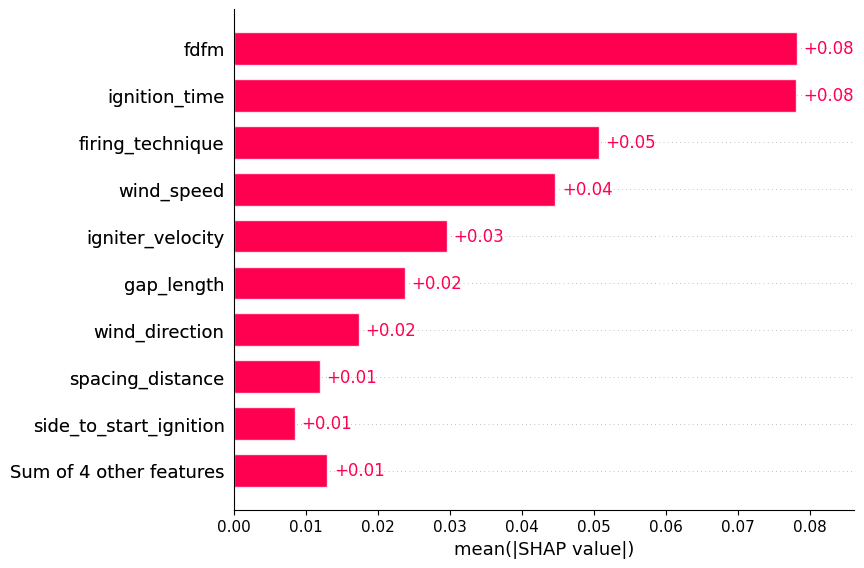

In [7]:
#Note for self: delete the IDs. make sure continuous inputs and discrete inputs are correctly shown and not any unnecesary data.

# Note: You can swap out the target variable manually as needed
target = 'surface_consumed'  # Change to 'midstory_consumed' or 'canopy_consumed' as needed
y = df_encoded[target]

# Combine selected features only
selected_features = continuous_inputs + discrete_inputs
X = df_encoded[selected_features]

# Drop rows where the target is NaN or infinite
valid_rows = y.replace([np.inf, -np.inf], np.nan).dropna().index

# Keep only valid rows in both X and y
X_clean = X.loc[valid_rows]
y_clean = y.loc[valid_rows]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(model, X_train)  # Use training data as background
shap_values = explainer(X_test)

# Display top features
print(f"Top features for {target}:")
shap.plots.bar(shap_values, max_display=10)

Top features for midstory_consumed:


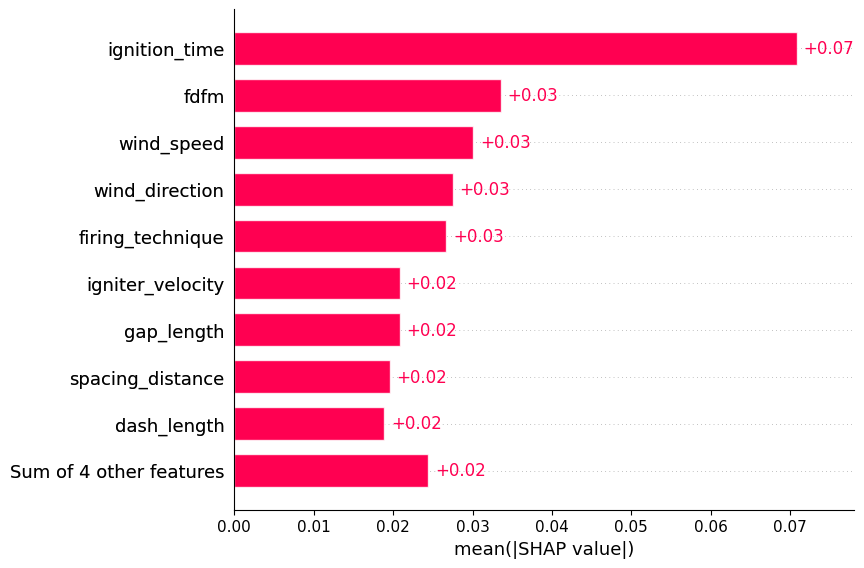

In [8]:
# Note: You can swap out the target variable manually as needed
target = 'midstory_consumed'  # Change to 'midstory_consumed' or 'canopy_consumed' as needed
y = df_encoded[target]

# Combine selected features only
selected_features = continuous_inputs + discrete_inputs
X = df_encoded[selected_features]

# Drop rows where the target is NaN or infinite
valid_rows = y.replace([np.inf, -np.inf], np.nan).dropna().index

# Keep only valid rows in both X and y
X_clean = X.loc[valid_rows]
y_clean = y.loc[valid_rows]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(model, X_train)  # Use training data as background
shap_values = explainer(X_test)

# Display top features
print(f"Top features for {target}:")
shap.plots.bar(shap_values, max_display=10)

Top features for canopy_consumed:


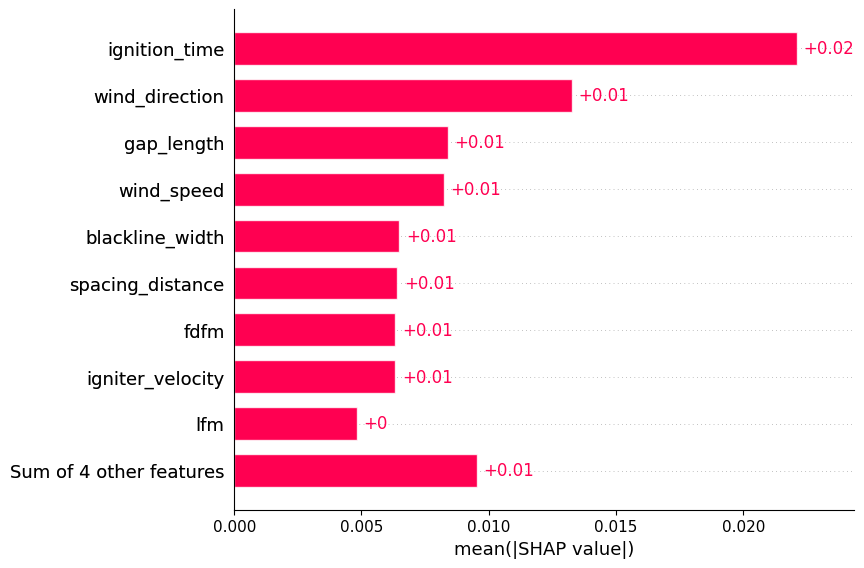

In [9]:
# Note: You can swap out the target variable manually as needed
target = 'canopy_consumed'  # Change to 'midstory_consumed' or 'canopy_consumed' as needed
y = df_encoded[target]

# Combine selected features only
selected_features = continuous_inputs + discrete_inputs
X = df_encoded[selected_features]

# Drop rows where the target is NaN or infinite
valid_rows = y.replace([np.inf, -np.inf], np.nan).dropna().index

# Keep only valid rows in both X and y
X_clean = X.loc[valid_rows]
y_clean = y.loc[valid_rows]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(model, X_train)  # Use training data as background
shap_values = explainer(X_test)

# Display top features
print(f"Top features for {target}:")
shap.plots.bar(shap_values, max_display=10)